# Notebook for plotting L-BFGS line-search results

In [ ]:
import torch
from torch.optim import Adam, Optimizer
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from functools import reduce
from tqdm import tqdm
import sys
sys.path.append('..')
from src.models import PINN
from src.train_utils import *

## Training models and collecting information from L-BFGS

We keep track of additional diagnostic information and evaluate loss with sampled stepsizes along the final direction.

### Convection:

`--seed 345 --pde convection --pde_params beta 40 --opt adam_lbfgs --opt_params switch_epochs 11000 adam_lr 0.0001 lbfgs_history_size 100 --num_layers 4 --num_neurons 200 --loss mse --num_x 257 --num_t 101 --num_res 10000 --epochs 12500`

### Reaction

`--seed 456 --pde reaction --pde_params rho 5 --opt adam_lbfgs --opt_params switch_epochs 11000 adam_lr 0.001 lbfgs_history_size 100 --num_layers 4 --num_neurons 200 --loss mse --num_x 257 --num_t 101 --num_res 10000 --epochs 12500`

### Wave

`--seed 567 --pde wave --pde_params beta 5 --opt adam_lbfgs --opt_params switch_epochs 11000 adam_lr 0.001 lbfgs_history_size 100 --num_layers 4 --num_neurons 200 --loss mse --num_x 257 --num_t 101 --num_res 10000 --epochs 12500`

### Modified L-BFGS

Based off of PyTorch [implementation](https://pytorch.org/docs/stable/_modules/torch/optim/lbfgs.html#LBFGS); added features to log diagnostic info.

In [ ]:
def _cubic_interpolate(x1, f1, g1, x2, f2, g2, bounds=None):
    # ported from https://github.com/torch/optim/blob/master/polyinterp.lua
    # Compute bounds of interpolation area
    if bounds is not None:
        xmin_bound, xmax_bound = bounds
    else:
        xmin_bound, xmax_bound = (x1, x2) if x1 <= x2 else (x2, x1)

    # Code for most common case: cubic interpolation of 2 points
    #   w/ function and derivative values for both
    # Solution in this case (where x2 is the farthest point):
    #   d1 = g1 + g2 - 3*(f1-f2)/(x1-x2);
    #   d2 = sqrt(d1^2 - g1*g2);
    #   min_pos = x2 - (x2 - x1)*((g2 + d2 - d1)/(g2 - g1 + 2*d2));
    #   t_new = min(max(min_pos,xmin_bound),xmax_bound);
    d1 = g1 + g2 - 3 * (f1 - f2) / (x1 - x2)
    d2_square = d1**2 - g1 * g2
    if d2_square >= 0:
        d2 = d2_square.sqrt()
        if x1 <= x2:
            min_pos = x2 - (x2 - x1) * ((g2 + d2 - d1) / (g2 - g1 + 2 * d2))
        else:
            min_pos = x1 - (x1 - x2) * ((g1 + d2 - d1) / (g1 - g2 + 2 * d2))
        return min(max(min_pos, xmin_bound), xmax_bound)
    else:
        return (xmin_bound + xmax_bound) / 2.


def _strong_wolfe(obj_func,
                  x,
                  t,
                  d,
                  f,
                  g,
                  gtd,
                  c1=1e-4,
                  c2=0.9,
                  tolerance_change=1e-9,
                  max_ls=25):
    # ported from https://github.com/torch/optim/blob/master/lswolfe.lua
    d_norm = d.abs().max()
    g = g.clone(memory_format=torch.contiguous_format)
    # evaluate objective and gradient using initial step
    f_new, g_new = obj_func(x, t, d)
    ls_func_evals = 1
    gtd_new = g_new.dot(d)
    ls_diagnostics = "Line Search Starts\n"
    tried_steps = [(t.item(), f)] if torch.is_tensor(t) else [(t, f)]
    # bracket an interval containing a point satisfying the Wolfe criteria
    t_prev, f_prev, g_prev, gtd_prev = 0, f, g, gtd
    done = False
    ls_iter = 0
    ls_diagnostics += "* Bracket Phase *\n"
    while ls_iter < max_ls:
        ls_diagnostics += "--- ls iter {} / t {:.15f} / loss {:.2e} / grad norm {:.2e} / gtd {:.2e} ---\n".format(ls_iter, t, f_new, g_new.norm(), gtd_new)
        # check conditions
        if f_new > (f + c1 * t * gtd) or (ls_iter > 1 and f_new >= f_prev):
            bracket = [t_prev, t]
            bracket_f = [f_prev, f_new]
            bracket_g = [g_prev, g_new.clone(memory_format=torch.contiguous_format)]
            bracket_gtd = [gtd_prev, gtd_new]
            if f_new > (f + c1 * t * gtd):
                ls_diagnostics += "Bracket Phase Exited: sufficient decrease cond. violated\n"
            else:
                ls_diagnostics += "Bracket Phase Exited: func. value increased\n"
            break

        if abs(gtd_new) <= -c2 * gtd:
            bracket = [t]
            bracket_f = [f_new]
            bracket_g = [g_new]
            done = True
            ls_diagnostics += "Line Search Exited: strong wolfe cond. satisfied\n"
            break

        if gtd_new >= 0:
            bracket = [t_prev, t]
            bracket_f = [f_prev, f_new]
            bracket_g = [g_prev, g_new.clone(memory_format=torch.contiguous_format)]
            bracket_gtd = [gtd_prev, gtd_new]
            ls_diagnostics += "Bracket Phase Exited: curvature cond. violated + directional derivative non-negative\n"
            break

        # interpolate
        min_step = t + 0.01 * (t - t_prev)
        max_step = t * 10
        tmp = t
        t = _cubic_interpolate(
            t_prev,
            f_prev,
            gtd_prev,
            t,
            f_new,
            gtd_new,
            bounds=(min_step, max_step))
        ls_diagnostics += "obtains new t {:.15f}\n".format(t)

        # next step
        t_prev = tmp
        f_prev = f_new
        g_prev = g_new.clone(memory_format=torch.contiguous_format)
        gtd_prev = gtd_new
        f_new, g_new = obj_func(x, t, d)
        ls_func_evals += 1
        gtd_new = g_new.dot(d)
        ls_iter += 1
        tried_steps.append((t.item(), f_new))

    # reached max number of iterations?
    if ls_iter == max_ls:
        bracket = [0, t]
        bracket_f = [f, f_new]
        bracket_g = [g, g_new]
        ls_diagnostics += "Line Search Exited: max number of evals reached\n"

    # zoom phase: we now have a point satisfying the criteria, or
    # a bracket around it. We refine the bracket until we find the
    # exact point satisfying the criteria
    insuf_progress = False
    # find high and low points in bracket
    low_pos, high_pos = (0, 1) if bracket_f[0] <= bracket_f[-1] else (1, 0)
    if not done and ls_iter < max_ls: ls_diagnostics += "* Zoom Phase *\n"
    while not done and ls_iter < max_ls:
        ls_diagnostics += "--- ls iter {} / bracket [{:.15f}, {:.15f}] ---\n".format(ls_iter, bracket[low_pos], bracket[high_pos])
        # line-search bracket is so small
        if abs(bracket[1] - bracket[0]) * d_norm < tolerance_change:
            ls_diagnostics += "Zoom Phase Exited: small bracket (dir inf norm {:.2e})\n".format(d_norm)
            break

        # compute new trial value
        t = _cubic_interpolate(bracket[0], bracket_f[0], bracket_gtd[0],
                               bracket[1], bracket_f[1], bracket_gtd[1])
        ls_diagnostics += "obtains new t inside the bracket {:.15f}\n".format(t)

        # test that we are making sufficient progress:
        # in case `t` is so close to boundary, we mark that we are making
        # insufficient progress, and if
        #   + we have made insufficient progress in the last step, or
        #   + `t` is at one of the boundary,
        # we will move `t` to a position which is `0.1 * len(bracket)`
        # away from the nearest boundary point.
        eps = 0.1 * (max(bracket) - min(bracket))
        if min(max(bracket) - t, t - min(bracket)) < eps:
            # interpolation close to boundary
            if insuf_progress or t >= max(bracket) or t <= min(bracket):
                # evaluate at 0.1 away from boundary
                if abs(t - max(bracket)) < abs(t - min(bracket)):
                    t = max(bracket) - eps
                else:
                    t = min(bracket) + eps
                insuf_progress = False
                ls_diagnostics += "moves t away from boundary {:.15f}\n".format(t)
            else:
                insuf_progress = True
                ls_diagnostics += "marked t close to boundary\n"
        else:
            insuf_progress = False

        # Evaluate new point
        f_new, g_new = obj_func(x, t, d)
        ls_func_evals += 1
        gtd_new = g_new.dot(d)
        ls_iter += 1
        tried_steps.append((t.item(), f_new))

        if f_new > (f + c1 * t * gtd) or f_new >= bracket_f[low_pos]:
            # Armijo condition not satisfied or not lower than lowest point
            bracket[high_pos] = t
            bracket_f[high_pos] = f_new
            bracket_g[high_pos] = g_new.clone(memory_format=torch.contiguous_format)
            bracket_gtd[high_pos] = gtd_new
            low_pos, high_pos = (0, 1) if bracket_f[0] <= bracket_f[1] else (1, 0)
            if f_new > (f + c1 * t * gtd):
                ls_diagnostics += "sufficient decrease cond. violated\n"
            else:
                ls_diagnostics += "func. value greater than lower boundary\n"
        else:
            if abs(gtd_new) <= -c2 * gtd:
                # Wolfe conditions satisfied
                done = True
                ls_diagnostics += "Zoom Phase Exited: strong wolfe cond. satisfied\n"
            elif gtd_new * (bracket[high_pos] - bracket[low_pos]) >= 0:
                # old high becomes new low
                bracket[high_pos] = bracket[low_pos]
                bracket_f[high_pos] = bracket_f[low_pos]
                bracket_g[high_pos] = bracket_g[low_pos]
                bracket_gtd[high_pos] = bracket_gtd[low_pos]
                ls_diagnostics += "switches bounds\n"

            # new point becomes new low
            bracket[low_pos] = t
            bracket_f[low_pos] = f_new
            bracket_g[low_pos] = g_new.clone(memory_format=torch.contiguous_format)
            bracket_gtd[low_pos] = gtd_new

        ls_diagnostics += "obtains new bracket [{:.15f}, {:.15f}] with loss {:.2e}, grad norm {:.2e}, and gtd {:.2e}\n".format(bracket[low_pos], bracket[high_pos], f_new, g_new.norm(), gtd_new)

    # return stuff
    t = bracket[low_pos]
    f_new = bracket_f[low_pos]
    g_new = bracket_g[low_pos]
    ls_diagnostics += "Line Search Ends (t {:.15f})\n".format(t)
    return f_new, g_new, t, ls_func_evals, ls_diagnostics, tried_steps


class LBFGS(Optimizer):
    """Implements L-BFGS algorithm.

    Heavily inspired by `minFunc
    <https://www.cs.ubc.ca/~schmidtm/Software/minFunc.html>`_.

    .. warning::
        This optimizer doesn't support per-parameter options and parameter
        groups (there can be only one).

    .. warning::
        Right now all parameters have to be on a single device. This will be
        improved in the future.

    .. note::
        This is a very memory intensive optimizer (it requires additional
        ``param_bytes * (history_size + 1)`` bytes). If it doesn't fit in memory
        try reducing the history size, or use a different algorithm.

    Args:
        lr (float): learning rate (default: 1)
        max_iter (int): maximal number of iterations per optimization step
            (default: 20)
        max_eval (int): maximal number of function evaluations per optimization
            step (default: max_iter * 1.25).
        tolerance_grad (float): termination tolerance on first order optimality
            (default: 1e-7).
        tolerance_change (float): termination tolerance on function
            value/parameter changes (default: 1e-9).
        history_size (int): update history size (default: 100).
        line_search_fn (str): either 'strong_wolfe' or None (default: None).
    """

    def __init__(self,
                 params,
                 lr=1,
                 max_iter=20,
                 max_eval=None,
                 tolerance_grad=1e-7,
                 tolerance_change=1e-9,
                 history_size=100,
                 line_search_fn=None):
        if max_eval is None:
            max_eval = max_iter * 5 // 4
        defaults = dict(
            lr=lr,
            max_iter=max_iter,
            max_eval=max_eval,
            tolerance_grad=tolerance_grad,
            tolerance_change=tolerance_change,
            history_size=history_size,
            line_search_fn=line_search_fn)
        super().__init__(params, defaults)

        if len(self.param_groups) != 1:
            raise ValueError("LBFGS doesn't support per-parameter options "
                             "(parameter groups)")

        self._params = self.param_groups[0]['params']
        self._numel_cache = None

    def _numel(self):
        if self._numel_cache is None:
            self._numel_cache = reduce(lambda total, p: total + p.numel(), self._params, 0)
        return self._numel_cache

    def _gather_flat_grad(self):
        views = []
        for p in self._params:
            if p.grad is None:
                view = p.new(p.numel()).zero_()
            elif p.grad.is_sparse:
                view = p.grad.to_dense().view(-1)
            else:
                view = p.grad.view(-1)
            views.append(view)
        return torch.cat(views, 0)

    def _add_grad(self, step_size, update):
        offset = 0
        for p in self._params:
            numel = p.numel()
            # view as to avoid deprecated pointwise semantics
            p.add_(update[offset:offset + numel].view_as(p), alpha=step_size)
            offset += numel
        assert offset == self._numel()

    def _clone_param(self):
        return [p.clone(memory_format=torch.contiguous_format) for p in self._params]

    def _set_param(self, params_data):
        for p, pdata in zip(self._params, params_data):
            p.copy_(pdata)

    def _directional_evaluate(self, closure, x, t, d):
        self._add_grad(t, d)
        loss = float(closure())
        flat_grad = self._gather_flat_grad()
        self._set_param(x)
        return loss, flat_grad

    @torch.no_grad()
    def step(self, closure):
        """Perform a single optimization step.

        Args:
            closure (Callable): A closure that reevaluates the model
                and returns the loss.
        """
        assert len(self.param_groups) == 1

        # Make sure the closure is always called with grad enabled
        closure = torch.enable_grad()(closure)

        group = self.param_groups[0]
        lr = group['lr']
        max_iter = group['max_iter']
        max_eval = group['max_eval']
        tolerance_grad = group['tolerance_grad']
        tolerance_change = group['tolerance_change']
        line_search_fn = group['line_search_fn']
        history_size = group['history_size']

        # NOTE: LBFGS has only global state, but we register it as state for
        # the first param, because this helps with casting in load_state_dict
        state = self.state[self._params[0]]
        state.setdefault('func_evals', 0)
        state.setdefault('n_iter', 0)
        state.setdefault('t_hist', [])
        state.setdefault('gtd_hist', [])
        state.setdefault('loss', [])
        state.setdefault('g_norm', [])
        state.setdefault('diagnostics', [])
        state.setdefault('ls_tried_steps', [])

        # evaluate initial f(x) and df/dx
        orig_loss = closure()
        loss = float(orig_loss)
        current_evals = 1
        state['func_evals'] += 1
        state['loss'].append(loss)
        state['t_hist'].append(0)
        state['gtd_hist'].append(0)

        flat_grad = self._gather_flat_grad()
        opt_cond = flat_grad.abs().max() <= tolerance_grad
        state['g_norm'].append(float(flat_grad.norm().cpu()))

        # optimal condition
        if opt_cond:
            state['diagnostics'].append("Step Exited: small grad norm (grad inf norm: {:.2e})".format(flat_grad.abs().max()))
            state['ls_tried_steps'].append(ls_tried_steps)
            return orig_loss

        # tensors cached in state (for tracing)
        d = state.get('d')
        t = state.get('t')
        old_dirs = state.get('old_dirs')
        old_stps = state.get('old_stps')
        ro = state.get('ro')
        H_diag = state.get('H_diag')
        prev_flat_grad = state.get('prev_flat_grad')
        prev_loss = state.get('prev_loss')

        n_iter = 0
        # optimize for a max of max_iter iterations
        while n_iter < max_iter:
            # keep track of nb of iterations
            n_iter += 1
            state['n_iter'] += 1

            iter_diagnostics = ""
            iter_diagnostics += "### step iter {} / global iter {} / loss {:.2e} / grad norm {:.2e} ###\n".format(n_iter, state['n_iter'], loss, flat_grad.norm())

            ############################################################
            # compute gradient descent direction
            ############################################################
            if state['n_iter'] == 1:
                d = flat_grad.neg()
                old_dirs = []
                old_stps = []
                ro = []
                H_diag = 1
            else:
                # do lbfgs update (update memory)
                y = flat_grad.sub(prev_flat_grad)
                s = d.mul(t)
                ys = y.dot(s)  # y*s
                if ys > 1e-10:
                    iter_diagnostics += "updates memory (ys: {:.2e})\n".format(ys)
                    # updating memory
                    if len(old_dirs) == history_size:
                        # shift history by one (limited-memory)
                        old_dirs.pop(0)
                        old_stps.pop(0)
                        ro.pop(0)

                    # store new direction/step
                    old_dirs.append(y)
                    old_stps.append(s)
                    ro.append(1. / ys)

                    # update scale of initial Hessian approximation
                    H_diag = ys / y.dot(y)  # (y*y)
                else:
                    iter_diagnostics += "skips updating (ys: {:.2e})\n".format(ys)

                # compute the approximate (L-BFGS) inverse Hessian
                # multiplied by the gradient
                num_old = len(old_dirs)

                if 'al' not in state:
                    state['al'] = [None] * history_size
                al = state['al']

                # iteration in L-BFGS loop collapsed to use just one buffer
                q = flat_grad.neg()
                for i in range(num_old - 1, -1, -1):
                    al[i] = old_stps[i].dot(q) * ro[i]
                    q.add_(old_dirs[i], alpha=-al[i])

                # multiply by initial Hessian
                # r/d is the final direction
                d = r = torch.mul(q, H_diag)
                for i in range(num_old):
                    be_i = old_dirs[i].dot(r) * ro[i]
                    r.add_(old_stps[i], alpha=al[i] - be_i)

            if prev_flat_grad is None:
                prev_flat_grad = flat_grad.clone(memory_format=torch.contiguous_format)
            else:
                prev_flat_grad.copy_(flat_grad)
            prev_loss = loss

            ############################################################
            # compute step length
            ############################################################
            # reset initial guess for step size
            if state['n_iter'] == 1:
                t = min(1., 1. / flat_grad.abs().sum()) * lr
            else:
                t = lr

            # directional derivative
            gtd = flat_grad.dot(d)  # g * d

            # directional derivative is below tolerance
            if gtd > -tolerance_change:
                iter_diagnostics += "Iter Exited: small directional derivative (gtd: {:.2e})".format(gtd)
                state['diagnostics'].append(iter_diagnostics)
                state['ls_tried_steps'].append([])
                break

            # optional line search: user function
            ls_func_evals = 0
            if line_search_fn is not None:
                # perform line search, using user function
                if line_search_fn != "strong_wolfe":
                    raise RuntimeError("only 'strong_wolfe' is supported")
                else:
                    x_init = self._clone_param()

                    def obj_func(x, t, d):
                        return self._directional_evaluate(closure, x, t, d)

                    loss, flat_grad, t, ls_func_evals, ls_diagnostics, ls_tried_steps = _strong_wolfe(
                        obj_func, x_init, t, d, loss, flat_grad, gtd)
                self._add_grad(t, d)
                opt_cond = flat_grad.abs().max() <= tolerance_grad
                iter_diagnostics += ls_diagnostics
                state['ls_tried_steps'].append(ls_tried_steps)
            else:
                # no line search, simply move with fixed-step
                self._add_grad(t, d)
                if n_iter != max_iter:
                    # re-evaluate function only if not in last iteration
                    # the reason we do this: in a stochastic setting,
                    # no use to re-evaluate that function here
                    with torch.enable_grad():
                        loss = float(closure())
                    flat_grad = self._gather_flat_grad()
                    opt_cond = flat_grad.abs().max() <= tolerance_grad
                    ls_func_evals = 1

            # update func eval
            current_evals += ls_func_evals
            state['func_evals'] += ls_func_evals
            state['loss'].append(loss)
            state['g_norm'].append(float(flat_grad.norm().cpu()))
            state['t_hist'].append(t)
            state['gtd_hist'].append(float(gtd.cpu()))
            iter_diagnostics += "obtains t {:.15f} with loss {:.2e} and grad norm {:.2e}\n".format(t, loss, flat_grad.norm())

            ############################################################
            # check conditions
            ############################################################
            if n_iter == max_iter:
                iter_diagnostics += "Iter Exited: max number of iterations reached"
                state['diagnostics'].append(iter_diagnostics)
                break

            if current_evals >= max_eval:
                iter_diagnostics += "Iter Exited: max number of evals reached"
                state['diagnostics'].append(iter_diagnostics)
                break

            # optimal condition
            if opt_cond:
                iter_diagnostics += "Iter Exited: small grad norm (grad inf norm: {:.2e})".format(flat_grad.abs().max())
                state['diagnostics'].append(iter_diagnostics)
                break

            # lack of progress
            if d.mul(t).abs().max() <= tolerance_change:
                iter_diagnostics += "Iter Exited: lack of step progress (dir inf norm: {:.2e} / grad inf norm: {:.2e})".format(d.abs().max(), flat_grad.abs().max())
                state['diagnostics'].append(iter_diagnostics)
                break

            if abs(loss - prev_loss) < tolerance_change:
                iter_diagnostics += "Iter Exited: lack of loss progress (dir inf norm: {:.2e} / grad inf norm: {:.2e})".format(d.abs().max(), flat_grad.abs().max())
                state['diagnostics'].append(iter_diagnostics)
                break

            state['diagnostics'].append(iter_diagnostics)

        state['d'] = d
        state['t'] = t
        state['old_dirs'] = old_dirs
        state['old_stps'] = old_stps
        state['ro'] = ro
        state['H_diag'] = H_diag
        state['prev_flat_grad'] = prev_flat_grad
        state['prev_loss'] = prev_loss

        return orig_loss

### Referencing the modified L-BFGS in Adam + L-BFGS

In [ ]:
class Adam_LBFGS(Optimizer):
    def __init__(self, params, switch_epochs, adam_params, lbfgs_params):
        # defaults = dict(switch_epoch=switch_epoch, adam_params=adam_params, lbfgs_params=lbfgs_params)

        self.switch_epochs = sorted(switch_epochs)
        self.params = list(params)
        self.adam = Adam(self.params, **adam_params)
        self.lbfgs_params = lbfgs_params
        # self.lbfgs = LBFGS(self.params, **lbfgs_params)

        super(Adam_LBFGS, self).__init__(self.params, defaults={})

        self.state['epoch'] = 0

    def step(self, closure=None):
        if self.state['epoch'] < self.switch_epochs[0]:
            self.adam.step(closure)
        else:
            # (Re)start LBFGS optimizer
            if self.state['epoch'] in self.switch_epochs:
                print(f'Starting LBFGS optimizer at epoch {self.state["epoch"]}')
                self.lbfgs = LBFGS(self.params, **self.lbfgs_params)
            self.lbfgs.step(closure)

        self.state['epoch'] += 1

### Utilities functions

- evaluate loss with sampled stepsizes at given direction
- determine stepsizes that satisfy strong Wolfe conditions
- train the model and perform necessary computations

In [ ]:
def directional_evaluate(model, predict_func, loss_func, direction, x, t, num_samples, stepsize_range):
    current_params = [p.clone(memory_format=torch.contiguous_format) for p in model.parameters()]

    sample_points = np.linspace(stepsize_range[0], stepsize_range[1], num_samples)
    sample_points = np.insert(sample_points, 0, 0) # first sample point corresponds to current model
    loss_vals = np.zeros(num_samples + 1)
    gtd_vals = np.zeros(num_samples + 1)
    for i, stepsize in enumerate(sample_points):
        # set model param values and zero out gradient
        with torch.no_grad():
            offset = 0
            for p in model.parameters():
                numel = p.numel()
                p.add_(direction[offset:offset + numel].view_as(p), alpha=stepsize)
                if p.grad is not None:
                    p.grad = None
                offset += numel

        # compute loss
        loss_res, loss_bc, loss_ic = loss_func(x, t, predict_func(x, t, model))
        loss = loss_res + loss_bc + loss_ic
        loss.backward()

        # get gradient
        views = []
        with torch.no_grad():
            for p in model.parameters():
                if p.grad is None:
                    view = p.new(p.numel()).zero_()
                elif p.grad.is_sparse:
                    view = p.grad.to_dense().view(-1)
                else:
                    view = p.grad.view(-1)
                views.append(view)
            flat_grad = torch.cat(views, 0)

        # record results
        loss_vals[i] = float(loss.item())
        gtd_vals[i] = float(flat_grad.dot(direction))

        if i == 0:
            current_loss = float(loss.item())
            current_gtd = float(flat_grad.dot(direction))
        else:
            loss_vals[i] = float(loss.item())
            gtd_vals[i] = float(flat_grad.dot(direction))

        # revert back to original params
        with torch.no_grad():
            for p, pdata in zip(model.parameters(), current_params):
                p.copy_(pdata)

    current_loss = loss_vals[0]
    current_gtd = gtd_vals[0]

    return current_loss, current_gtd, sample_points[1:], loss_vals[1:], gtd_vals[1:]

def identify_strong_wolfe(c1, c2, current_loss, current_gtd, sample_points, loss_vals, gtd_vals):
    sample_points = np.array(sample_points)
    loss_vals = np.array(loss_vals)
    gtd_vals = np.array(gtd_vals)

    positive_stepsize_cond = sample_points > 0
    decreasing_loss_cond = loss_vals < current_loss
    armijo_cond = loss_vals <= (current_loss + c1 * sample_points * current_gtd)
    curvature_cond = np.abs(gtd_vals) <= (-c2 * current_gtd)

    indices = np.where(positive_stepsize_cond * decreasing_loss_cond * armijo_cond * curvature_cond)[0]

    return indices

def compute_ls_info(initial_seed, pde_name, pde_params, switch_epochs, adam_lr, lbfgs_history_size, num_layers, num_neurons, loss_name, num_x, num_t, num_res, num_epochs, device, num_samples, stepsize_range, c1, c2):
    # initializations
    set_random_seed(initial_seed)

    model = PINN(in_dim=2, hidden_dim=num_neurons, out_dim=1, num_layer=num_layers).to(device)
    model.apply(init_weights)

    x_range, t_range, loss_func, pde_coefs = get_pde(pde_name, pde_params, loss_name)
    opt = Adam_LBFGS(model.parameters(), switch_epochs=switch_epochs, adam_params={"lr": adam_lr}, lbfgs_params={"history_size": lbfgs_history_size, "line_search_fn": "strong_wolfe"})

    x, t, data_params = get_data(x_range, t_range, num_x, num_t, random=True, num_res_samples=num_res, device=device)

    loss_hist = []
    loss_res_hist = []
    loss_bc_hist = []
    loss_ic_hist = []
    grad_norm_hist = []

    loss_res, loss_bc, loss_ic = loss_func(x, t, predict(x, t, model))
    loss = loss_res + loss_bc + loss_ic

    loss_hist.append(loss.item())
    loss_res_hist.append(loss_res.item())
    loss_bc_hist.append(loss_bc.item())
    loss_ic_hist.append(loss_ic.item())

    for i in (progress_bar:=tqdm(range(num_epochs), ncols=125)):
        # training
        model.train()
        def closure():
            opt.zero_grad()
            outputs = predict(x, t, model)
            loss_res, loss_bc, loss_ic = loss_func(x, t, outputs)
            loss = loss_res + loss_bc + loss_ic
            loss.backward()

            return loss

        opt.step(closure)

        # evaluation
        model.eval()

        with torch.no_grad():
            for p in model.parameters():
                if p.grad is not None:
                    p.grad = None

        loss_res, loss_bc, loss_ic = loss_func(x, t, predict(x, t, model))
        loss = loss_res + loss_bc + loss_ic
        loss.backward()

        grad_norm = 0
        for p in model.parameters():
            grad_norm += p.grad.norm().item() ** 2
        grad_norm = grad_norm ** 0.5

        loss_hist.append(loss.item())
        loss_res_hist.append(loss_res.item())
        loss_bc_hist.append(loss_bc.item())
        loss_ic_hist.append(loss_ic.item())
        grad_norm_hist.append(grad_norm)

        progress_bar.set_postfix_str("res {:.2e} / bc {:.2e} / ic {:.2e} / grad_norm {:.2e}".format(loss_res_hist[-1], loss_bc_hist[-1], loss_ic_hist[-1], grad_norm))

    # testing
    x_test, t_test, data_params_test = get_data(x_range, t_range, int((num_x - 1) / 2) + 1, num_t, random=False, device=device)
    with torch.no_grad():
        predictions = torch.vstack(predict(x_test, t_test, model)).cpu().detach().numpy()
    targets = get_ref_solutions(pde_name, pde_coefs, x_test, t_test, data_params_test)
    test_l1re = l1_relative_error(predictions, targets)
    test_l2re = l2_relative_error(predictions, targets)

    print("final loss {:.2e} / test l2rs {:.2e}".format(loss_hist[-1], test_l2re))
    print(opt.lbfgs.state_dict()["state"][0]["diagnostics"][-1])

    # evaluate loss along the last idenfitied update direction
    direction = opt.lbfgs.state_dict()["state"][0]["d"]
    current_loss, current_gtd, sample_points, loss_vals, gtd_vals = directional_evaluate(model, predict, loss_func, direction, x, t, num_samples, stepsize_range)
    strong_wolfe_points = identify_strong_wolfe(c1, c2, current_loss, current_gtd, sample_points, loss_vals, gtd_vals)

    # save the results
    torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'adam_state_dict': opt.adam.state_dict(),
            'lbfgs_state_dict': opt.lbfgs.state_dict(),
            'loss_hist': loss_hist,
            'loss_res_hist': loss_res_hist,
            'loss_bc_hist': loss_bc_hist,
            'loss_ic_hist': loss_ic_hist,
            'grad_norm_hist': grad_norm_hist,
            'sample_points': sample_points,
            'loss_vals': loss_vals,
            'gtd_vals': gtd_vals,
            'strong_wolfe_points': strong_wolfe_points
            }, 'ls_' + pde_name)

### Training PINNs

In [ ]:
device = "cuda"
num_samples = int(1e4)
stepsize_range = [0,1]
c1 = 1e-4
c2 = 0.9

run_specs = [
  {'initial_seed': 345,
   'pde_name': "convection",
   'pde_params': ["beta", "40"],
   'switch_epochs': [11000],
   'adam_lr': 0.0001,
   'lbfgs_history_size': 100,
   'num_layers': 4,
   'num_neurons': 200,
   'loss_name': "mse",
   'num_x': 257,
   'num_t': 101,
   'num_res': 10000,
   'num_epochs': 12500
  },
  {'initial_seed': 456,
   'pde_name': "reaction",
   'pde_params': ["rho", "5"],
   'switch_epochs': [11000],
   'adam_lr': 0.001,
   'lbfgs_history_size': 100,
   'num_layers': 4,
   'num_neurons': 200,
   'loss_name': "mse",
   'num_x': 257,
   'num_t': 101,
   'num_res': 10000,
   'num_epochs': 12500
  },
  {'initial_seed': 567,
   'pde_name': "wave",
   'pde_params': ["beta", "5"],
   'switch_epochs': [11000],
   'adam_lr': 0.001,
   'lbfgs_history_size': 100,
   'num_layers': 4,
   'num_neurons': 200,
   'loss_name': "mse",
   'num_x': 257,
   'num_t': 101,
   'num_res': 10000,
   'num_epochs': 12500
  }
]

for run in run_specs:
  initial_seed = run['initial_seed']
  pde_name = run['pde_name']
  pde_params = run['pde_params']
  switch_epochs = run['switch_epochs']
  adam_lr = run['adam_lr']
  lbfgs_history_size = run['lbfgs_history_size']
  num_layers = run['num_layers']
  num_neurons = run['num_neurons']
  loss_name = run['loss_name']
  num_x = run['num_x']
  num_t = run['num_t']
  num_res = run['num_res']
  num_epochs = run['num_epochs']

  compute_ls_info(initial_seed=initial_seed,
                  pde_name=pde_name,
                  pde_params=pde_params,
                  switch_epochs=switch_epochs,
                  adam_lr=adam_lr,
                  lbfgs_history_size=lbfgs_history_size,
                  num_layers=num_layers,
                  num_neurons=num_neurons,
                  loss_name=loss_name,
                  num_x=num_x,
                  num_t=num_t,
                  num_res=num_res,
                  num_epochs=num_epochs,
                  device=device,
                  num_samples=num_samples,
                  stepsize_range=stepsize_range,
                  c1=c1,
                  c2=c2
                )

## Making plots

We plot the best runs (in terms of L2 relative error) for each PDE problem in its "hardest setting".

- Convection: final test L2RE 0.004193487111479044
- Reaction: final test L2RE 0.029103083536028865
- Wave: final test L2RE 0.07878360897302628

In [ ]:
def get_title(pde_name, pde_params):
  if pde_name == "convection":
    return f'Convection, $\\beta = {pde_params[1]}$'
  if pde_name == "reaction":
    return f'Reaction, $\\rho = {pde_params[1]}$'
  elif pde_name == "wave":
    return f'Wave, $\\beta = {pde_params[1]}$'

In [ ]:
# load saved results
pdes = [('convection', ['beta', '40']), ('reaction', ['rho', '5']), ('wave', ['beta', '5'])]
saved_results = {}
for pde_name, _ in pdes:
  saved_results[pde_name] = torch.load('ls_' + pde_name, map_location=torch.device('cpu'))

# make sure texts are rendered in serif via LaTex
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [ ]:
# loss in the final search direction with stepsizes between 0 and 1
def plot_line_search_multi_pde(pdes, saved_results, line_colors, line_styles, line_orders, font_size, folder_path, filename):
  mpl.rcParams.update({'font.size': font_size})

  nrows = 1
  ncols = len(pdes)

  fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))

  legend_elements = [
    # plt.Line2D([0], [0], color=line_colors['loss'], linestyle=line_styles['loss'], label='Loss'),
    plt.Line2D([0], [0], color='w', markerfacecolor=line_colors['strong_wolfe'], marker=line_styles['strong_wolfe'], markersize=10, label='Satisfactory stepsize'),
    plt.Line2D([0], [0], color='w', markerfacecolor=line_colors['assessed'], marker=line_styles['assessed'], markersize=10, label='Assessed stepsize')
  ]

  for col, (pde_name, pde_params) in enumerate(pdes):
    pde_result = saved_results[pde_name]

    sampled_stepsizes = pde_result['sample_points']
    sampled_loss_vals = pde_result['loss_vals']
    strong_wolfe_idx = pde_result['strong_wolfe_points']
    assessed_stepsizes = []
    assessed_loss_vals = []
    for stepsize, loss in pde_result['lbfgs_state_dict']['state'][0]['ls_tried_steps'][-1]:
      assessed_stepsizes.append(stepsize)
      assessed_loss_vals.append(loss)

    ax = axs[col]
    ax.semilogy(sampled_stepsizes, sampled_loss_vals, color=line_colors['loss'], linestyle=line_styles['loss'], zorder=line_orders['loss'])
    ax.scatter(sampled_stepsizes[strong_wolfe_idx], sampled_loss_vals[strong_wolfe_idx], color=line_colors['strong_wolfe'], marker=line_styles['strong_wolfe'], zorder=line_orders['strong_wolfe'])
    ax.scatter(assessed_stepsizes, assessed_loss_vals, color=line_colors['assessed'], zorder=line_orders['assessed'])

    ax.set_ylabel('Loss')
    ax.set_xlabel('Stepsize')
    ax.set_title(get_title(pde_name, pde_params))

  fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])

  if not os.path.exists(folder_path):
    os.makedirs(folder_path)

  filename = filename + '.pdf'
  fig.savefig(os.path.join(folder_path, filename), bbox_inches='tight')
  plt.show()


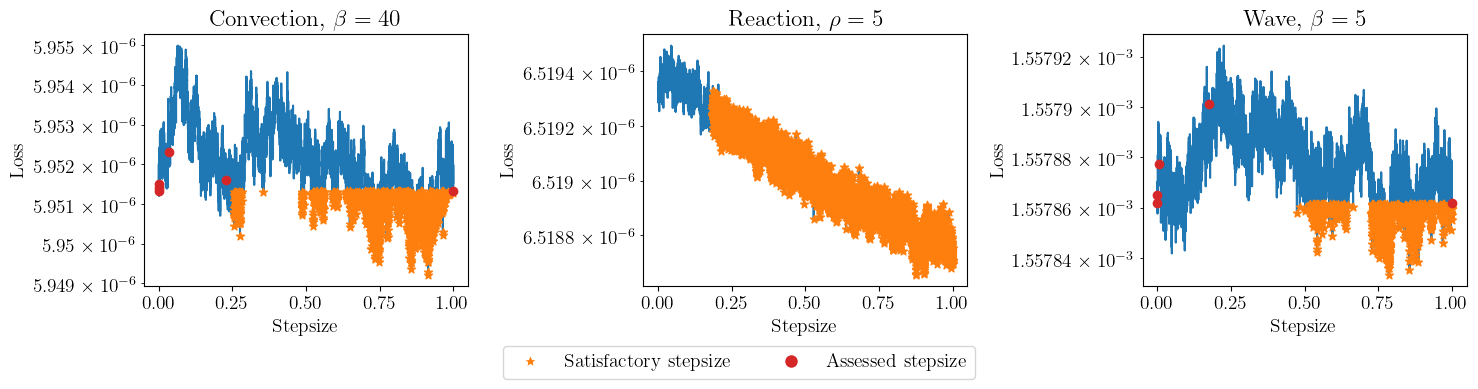

In [ ]:
line_colors = {
  'loss': 'tab:blue',
  'strong_wolfe': 'tab:orange',
  'assessed': 'tab:red'
}
line_styles = {
  'loss': 'solid',
  'strong_wolfe': '*',
  'assessed': 'o'
}
line_orders = {
  'loss': 1,
  'strong_wolfe': 2,
  'assessed': 3
}
plot_line_search_multi_pde(pdes, saved_results, line_colors, line_styles, line_orders, font_size=14, folder_path='line_search_plots', filename='line_search_multi_pde')